<a href="https://colab.research.google.com/github/gustavoramos82/Texto-Stress/blob/main/Prevendo_Stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevendo Stress a Partir de um Texto

Neste notebook será feito uma previsão , apartir de dados obtido do *kaggle* (que pode ser obtido [aqui](https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction) na qual será avaliado se o texto é de stress ou não.

Será feito uma análise dos dados, pré- processamento, modelagem e análise dos resultados.

In [ ]:
!pip install catboost
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from yellowbrick.text import TSNEVisualizer

In [ ]:
stress = pd.read_csv('/content/drive/MyDrive/Datasets/Stress.csv')
stress.drop(['post_id','sentence_range','confidence','social_timestamp'],axis=1,inplace=True) # Excluindo as colunas que não será utilizado
stress.head()

,subreddit,text,label
0,ptsd,"He said he had not felt that way before, sugge...",1
1,assistance,"Hey there r/assistance, Not sure if this is th...",0
2,ptsd,My mom then hit me with the newspaper and it s...,1
3,relationships,"until i met my new boyfriend, he is amazing, h...",1
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1


In [ ]:
stress.shape

(2838, 3)

### Dicionário dos Dados

- **subreddit**: Comunidade de onde o texto foi retirado.
- **texto**: texto que será utilizado para a detecção de stresse.
- **label**: 1 se for stresse, 0 caso contrário.

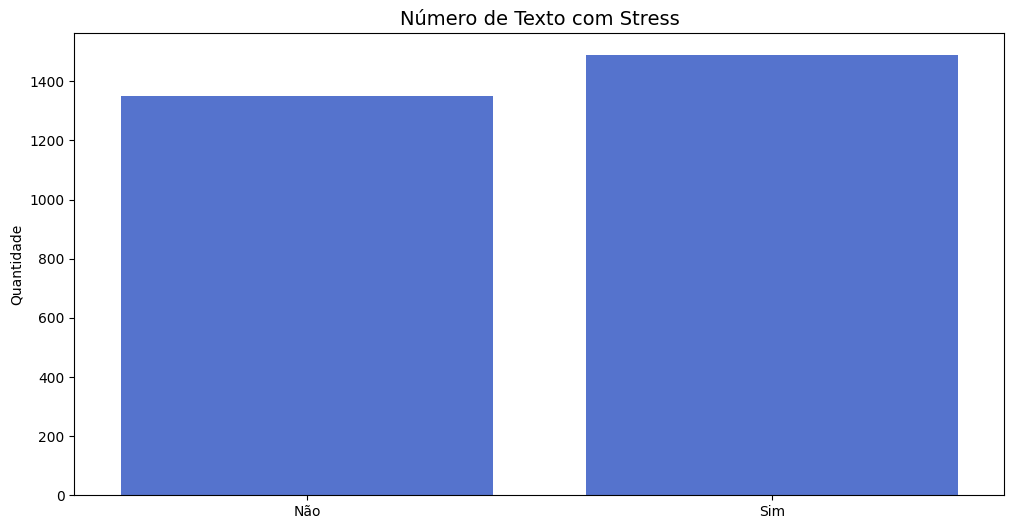

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Número de Texto com Stress',fontsize=14)
sns.countplot(x='label',data=stress,color='royalblue')
plt.xlabel('')
plt.xticks([0,1],['Não','Sim'])
plt.ylabel('Quantidade');


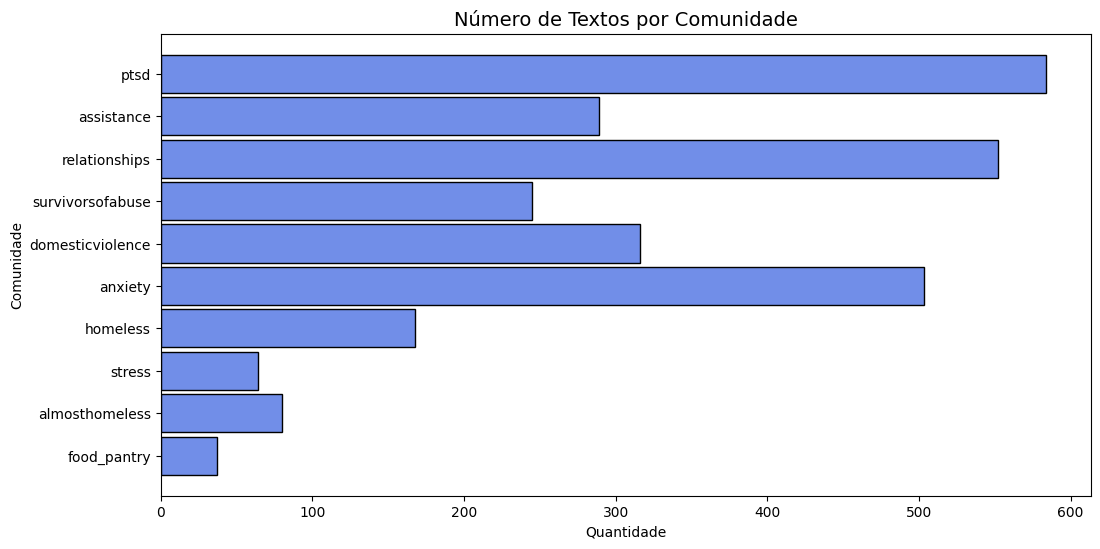

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Número de Textos por Comunidade',fontsize=14)
sns.histplot(y='subreddit',data=stress,color='royalblue',shrink=.9)
plt.ylabel('Comunidade')
plt.xlabel('Quantidade');

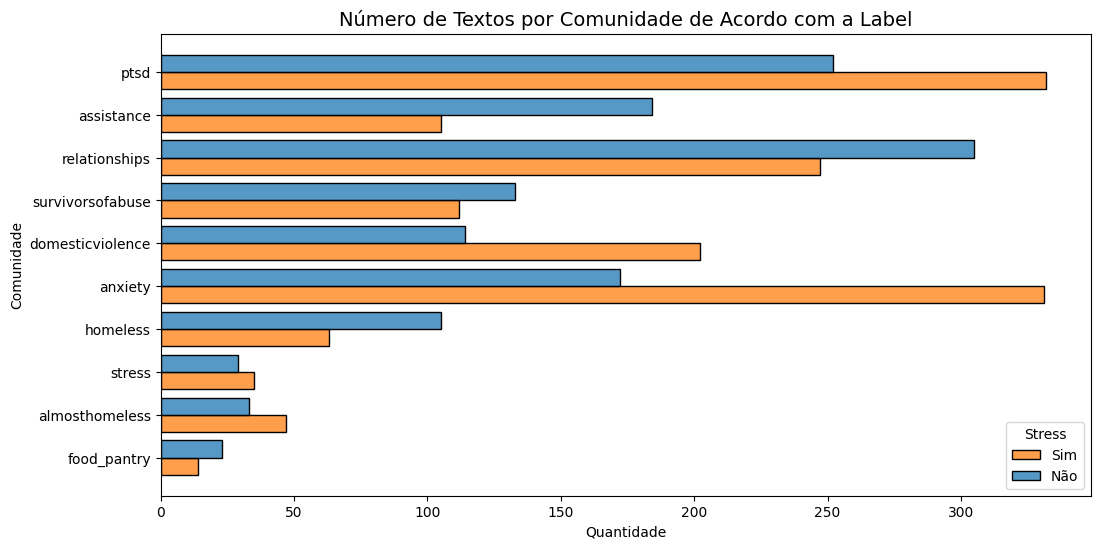

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Número de Textos por Comunidade de Acordo com a Label',fontsize=14)
sns.histplot(y='subreddit',data=stress,color='royalblue',hue='label',multiple="dodge",
             shrink=.8)
plt.ylabel('Comunidade')
plt.xlabel('Quantidade')
plt.legend(['Sim','Não'],title='Stress');

## Pré-Processamento



In [ ]:
nltk.download('stopwords')
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean(text):                                       # function for cleaning the text column             
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stress['text'] = stress['text'].apply(clean)

In [ ]:
stress.head()

,subreddit,text,label
0,ptsd,said felt way sugget go rest trigger ahead you...,1
1,assistance,hey rassist sure right place post goe im curr...,0
2,ptsd,mom hit newspap shock would know dont like pla...,1
3,relationships,met new boyfriend amaz kind sweet good student...,1
4,survivorsofabuse,octob domest violenc awar month domest violenc...,1


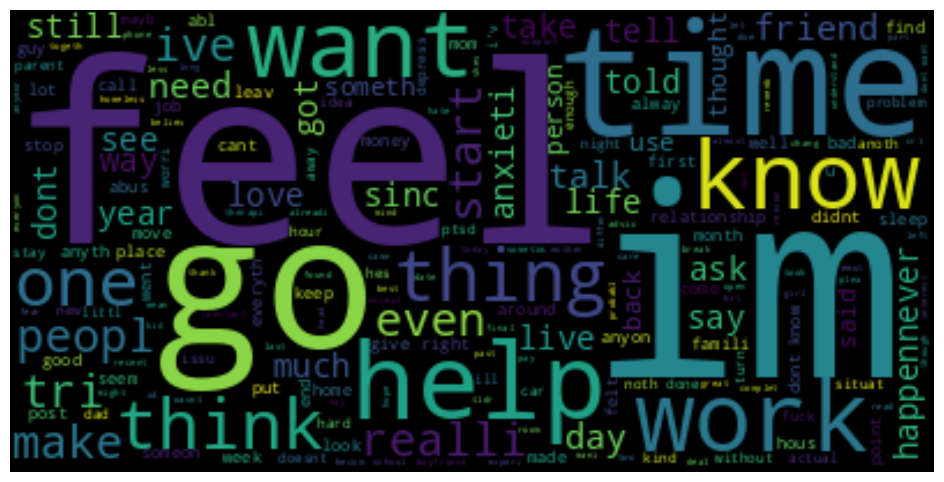

In [ ]:
text = " ".join(i for i in stress.text)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Separando por label

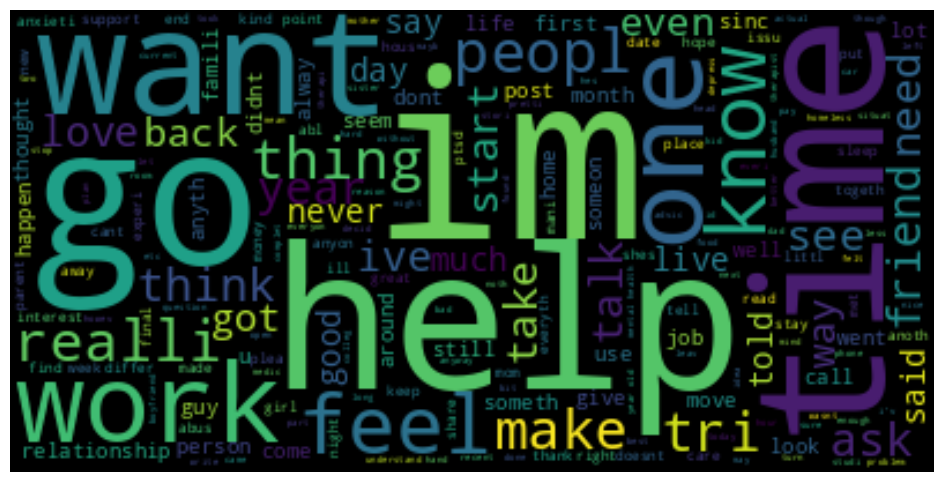

In [ ]:
text0 = " ".join(i for i in stress[stress['label']==0]['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text0)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

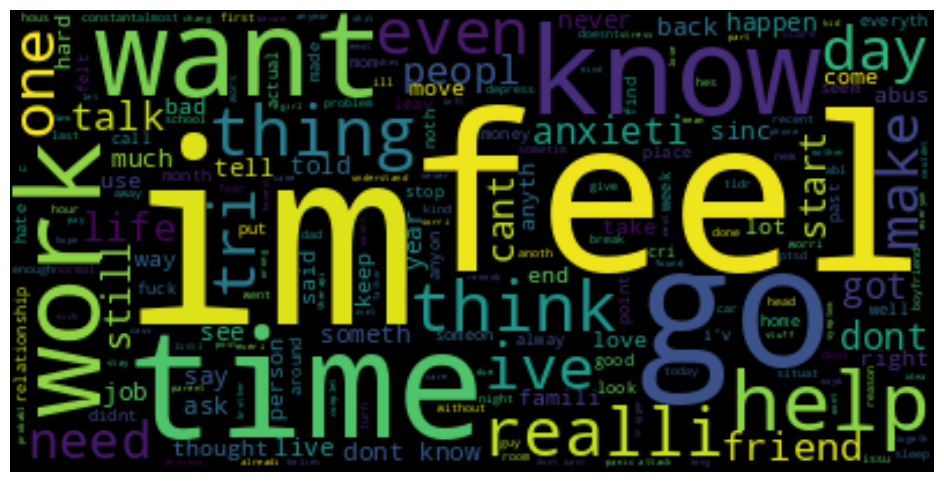

In [ ]:
text1 = " ".join(i for i in stress[stress['label']==1]['text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="black").generate(text1)
plt.figure( figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modelagem

In [ ]:
cv = CountVectorizer()
x = cv.fit_transform(stress.text)
y = stress.label

/usr/local/lib/python3.9/dist-packages/yellowbrick/text/tsne.py:401: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  self.ax.scatter(


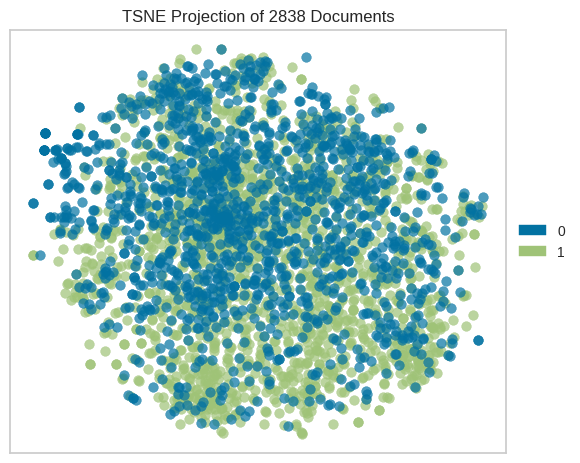

<Axes: title={'center': 'TSNE Projection of 2838 Documents'}>

In [ ]:
tsne = TSNEVisualizer()
tsne.fit(x, y)
tsne.show()

In [ ]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                test_size=0.3, 
                                                random_state=42)

Regressão Logistica

In [ ]:
rg = LogisticRegression()
rg.fit(x_treino,y_treino)
rg_pred = rg.predict(x_teste)

In [ ]:
print(classification_report(y_teste, rg_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7154    0.6618    0.6876       414
           1     0.7015    0.7511    0.7255       438

    accuracy                         0.7077       852
   macro avg     0.7084    0.7065    0.7065       852
weighted avg     0.7083    0.7077    0.7071       852



Knn

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_treino,y_treino)
knn_pred = knn.predict(x_teste)


In [ ]:
print(classification_report(y_teste, knn_pred,digits=4))

              precision    recall  f1-score   support

           0     0.5156    0.9565    0.6701       414
           1     0.7857    0.1507    0.2529       438

    accuracy                         0.5423       852
   macro avg     0.6507    0.5536    0.4615       852
weighted avg     0.6545    0.5423    0.4556       852



Svm

In [ ]:
svm = SVC(kernel='sigmoid')
svm.fit(x_treino,y_treino)
svm_pred = svm.predict(x_teste)


In [ ]:
print(classification_report(y_teste, svm_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7181    0.7198    0.7189       414
           1     0.7346    0.7329    0.7337       438

    accuracy                         0.7265       852
   macro avg     0.7263    0.7263    0.7263       852
weighted avg     0.7265    0.7265    0.7265       852



Naive Bayes

In [ ]:
mn = MultinomialNB()
mn.fit(x_treino,y_treino)
mn_pred = mn.predict(x_teste)


In [ ]:
print(classification_report(y_teste, mn_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8077    0.6087    0.6942       414
           1     0.7000    0.8630    0.7730       438

    accuracy                         0.7394       852
   macro avg     0.7538    0.7359    0.7336       852
weighted avg     0.7523    0.7394    0.7347       852



Árvore de Decisão

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(x_treino,y_treino)
tree_pred = tree.predict(x_teste)

In [ ]:
print(classification_report(y_teste, tree_pred,digits=4))

              precision    recall  f1-score   support

           0     0.5864    0.5821    0.5842       414
           1     0.6077    0.6119    0.6098       438

    accuracy                         0.5974       852
   macro avg     0.5970    0.5970    0.5970       852
weighted avg     0.5973    0.5974    0.5974       852



Random Forest

In [ ]:
rf = RandomForestClassifier(criterion='entropy')
rf.fit(x_treino,y_treino)
rf_pred = rf.predict(x_teste)

In [ ]:
print(classification_report(y_teste, rf_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7628    0.6135    0.6801       414
           1     0.6917    0.8196    0.7503       438

    accuracy                         0.7195       852
   macro avg     0.7272    0.7166    0.7152       852
weighted avg     0.7262    0.7195    0.7161       852



Extra Tree

In [ ]:
extra_tree = ExtraTreesClassifier(criterion='entropy')
extra_tree.fit(x_treino,y_treino)
extra_tree_pred = extra_tree.predict(x_teste)

In [ ]:
print(classification_report(y_teste, extra_tree_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7870    0.6159    0.6911       414
           1     0.6989    0.8425    0.7640       438

    accuracy                         0.7324       852
   macro avg     0.7430    0.7292    0.7275       852
weighted avg     0.7417    0.7324    0.7285       852



Gradiente Boosting

In [ ]:
gb = GradientBoostingClassifier()
gb.fit(x_treino,y_treino)
gb_pred = gb.predict(x_teste)

In [ ]:
print(classification_report(y_teste, gb_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6990    0.6787    0.6887       414
           1     0.7044    0.7237    0.7140       438

    accuracy                         0.7019       852
   macro avg     0.7017    0.7012    0.7013       852
weighted avg     0.7018    0.7019    0.7017       852



Catboost

In [ ]:
cat = CatBoostClassifier()
cat.fit(x_treino,y_treino)
cat_pred = cat.predict(x_teste)

Learning rate set to 0.013809
0:	learn: 0.6920278	total: 129ms	remaining: 2m 8s
1:	learn: 0.6904633	total: 176ms	remaining: 1m 27s
2:	learn: 0.6892676	total: 224ms	remaining: 1m 14s
3:	learn: 0.6881182	total: 280ms	remaining: 1m 9s
4:	learn: 0.6868698	total: 349ms	remaining: 1m 9s
5:	learn: 0.6853414	total: 400ms	remaining: 1m 6s
6:	learn: 0.6838941	total: 464ms	remaining: 1m 5s
7:	learn: 0.6822669	total: 532ms	remaining: 1m 6s
8:	learn: 0.6807462	total: 594ms	remaining: 1m 5s
9:	learn: 0.6794220	total: 655ms	remaining: 1m 4s
10:	learn: 0.6781078	total: 732ms	remaining: 1m 5s
11:	learn: 0.6770015	total: 795ms	remaining: 1m 5s
12:	learn: 0.6758967	total: 875ms	remaining: 1m 6s
13:	learn: 0.6749257	total: 930ms	remaining: 1m 5s
14:	learn: 0.6740784	total: 979ms	remaining: 1m 4s
15:	learn: 0.6729829	total: 1.03s	remaining: 1m 3s
16:	learn: 0.6718240	total: 1.09s	remaining: 1m 3s
17:	learn: 0.6707284	total: 1.16s	remaining: 1m 3s
18:	learn: 0.6699682	total: 1.22s	remaining: 1m 3s
19:	learn

In [ ]:
print(classification_report(y_teste, gb_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6990    0.6787    0.6887       414
           1     0.7044    0.7237    0.7140       438

    accuracy                         0.7019       852
   macro avg     0.7017    0.7012    0.7013       852
weighted avg     0.7018    0.7019    0.7017       852



XGboost

In [ ]:
xg = XGBClassifier()
xg.fit(x_treino,y_treino)
xg_pred = xg.predict(x_teste)

In [ ]:
print(classification_report(y_teste, xg_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6893    0.6377    0.6625       414
           1     0.6802    0.7283    0.7034       438

    accuracy                         0.6843       852
   macro avg     0.6847    0.6830    0.6830       852
weighted avg     0.6846    0.6843    0.6835       852



In [ ]:
modelos = ['Regressão logistica','KNN','SVM com Kernel Sigmoid','Naive Bayes (Multinomial)',
           'Árvore de Decisão','Random Forest','Extra Tree','Gradiente Boosting','Xgboost','Catbbost']

acuracia = [accuracy_score(y_teste, rg_pred),accuracy_score(y_teste, knn_pred),accuracy_score(y_teste, svm_pred),
            accuracy_score(y_teste, mn_pred),accuracy_score(y_teste, tree_pred),accuracy_score(y_teste, rf_pred),
            accuracy_score(y_teste, extra_tree_pred),accuracy_score(y_teste, gb_pred),accuracy_score(y_teste, xg_pred),
            accuracy_score(y_teste, cat_pred)]

In [ ]:
recall = [recall_score(y_teste, rg_pred),recall_score(y_teste, knn_pred),recall_score(y_teste, svm_pred),
            recall_score(y_teste, mn_pred),recall_score(y_teste, tree_pred),recall_score(y_teste, rf_pred),
            recall_score(y_teste, extra_tree_pred),recall_score(y_teste, gb_pred),recall_score(y_teste, xg_pred),
            recall_score(y_teste, cat_pred)]

f1 = [f1_score(y_teste, rg_pred),f1_score(y_teste, knn_pred),f1_score(y_teste, svm_pred),
            f1_score(y_teste, mn_pred),f1_score(y_teste, tree_pred),f1_score(y_teste, rf_pred),
            f1_score(y_teste, extra_tree_pred),f1_score(y_teste, gb_pred),f1_score(y_teste, xg_pred),
            f1_score(y_teste, cat_pred)]

In [ ]:
precision = [precision_score(y_teste, rg_pred),precision_score(y_teste, knn_pred),precision_score(y_teste, svm_pred),
            precision_score(y_teste, mn_pred),precision_score(y_teste, tree_pred),precision_score(y_teste, rf_pred),
            precision_score(y_teste, extra_tree_pred),  precision_score(y_teste, gb_pred), precision_score(y_teste, xg_pred),
              precision_score(y_teste, cat_pred)]

In [ ]:
metrica = {'Nome do Modelo':modelos,'Acc':acuracia,'Pre':precision,'Rec':recall,'F1':f1}

In [ ]:
pd.DataFrame(metrica)

,Nome do Modelo,Acc,Pre,Rec,F1
0,Regressão logistica,0.707746,0.701493,0.751142,0.725469
1,KNN,0.542254,0.785714,0.150685,0.252874
2,SVM com Kernel Sigmoid,0.726526,0.734554,0.732877,0.733714
3,Naive Bayes (Multinomial),0.739437,0.700000,0.863014,0.773006
4,Árvore de Decisão,0.597418,0.607710,0.611872,0.609784
5,Random Forest,0.719484,0.691715,0.819635,0.750261
6,Extra Tree,0.732394,0.698864,0.842466,0.763975
7,Gradiente Boosting,0.701878,0.704444,0.723744,0.713964
8,Xgboost,0.684272,0.680171,0.728311,0.703418
9,Catbbost,0.717136,0.720358,0.735160,0.727684


melhora dos parametos

In [ ]:
param_grid = {'C':np.arange(0,11,0.1),'gamma':['scale','auto'],'coef0':np.arange(0,1.1,0.1)}
search = HalvingGridSearchCV(SVC(kernel='sigmoid'), param_grid).fit(x_teste, y_teste)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
110 fits failed out of a total of 12100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_param

In [ ]:
search.best_params_  

{'C': 2.9000000000000004, 'coef0': 0.5, 'gamma': 'scale'}

In [ ]:
svm_2 = SVC(kernel='sigmoid',C=2.9,coef0=0.5,gamma='scale')
svm_2.fit(x_treino,y_treino) 
svm_2_pred = svm_2.predict(x_teste)

In [ ]:
print(classification_report(y_teste, svm_2_pred,digits=4))

              precision    recall  f1-score   support

           0     0.7226    0.7174    0.7200       414
           1     0.7347    0.7397    0.7372       438

    accuracy                         0.7289       852
   macro avg     0.7287    0.7286    0.7286       852
weighted avg     0.7288    0.7289    0.7288       852



In [ ]:
print(accuracy_score(y_teste, svm_2_pred))
print(precision_score(y_teste, svm_2_pred))
print(recall_score(y_teste, svm_2_pred))
print(f1_score(y_teste, svm_2_pred))

0.7288732394366197
0.7346938775510204
0.7397260273972602
0.7372013651877133
